In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
# import pygame as pg
from scipy.spatial import Delaunay
import time
from geompreds import orient2d, incircle
# import gmsh
import sys
# from bisect import bisect
from collections import deque

In [2]:
%load_ext line_profiler

In [3]:
class TriangularMesh:
    def __init__(self, vertices=None, faces=None, halfedges=None):
        self.vertices = [] if vertices == None else vertices
        self.faces = set() if faces == None else faces
        self.halfedges = set() if halfedges == None else halfedges
        self.version = int(sys.version.split('.')[1]) >= 10

    def sort_vertices(self):
        self.vertices.sort(key=lambda x: x.Hilbert)

    def add_triangle(self, vertices, halfedges=None, out=False):
        halfedges = [Halfedge() for _ in range(3)] if halfedges is None else halfedges
        face = Face(halfedge=halfedges[0], index=min([v.index for v in vertices]))
        for i in range(3):
            halfedges[i].next = halfedges[i-2]
            halfedges[i].prev = halfedges[i-1]
            halfedges[i].vertex = vertices[i]
            halfedges[i].facet = face
            vertices[i].halfedge = halfedges[i]
        self.halfedges.update(halfedges)
        self.faces.add(face)
        if out:
            return halfedges
    
    def add_mesh(self, mesh):
        self.vertices += mesh.vertices
        self.faces.update(mesh.faces)
        self.halfedges.update(mesh.halfedges)

    def rem_mesh(self, mesh):
        # self.vertices.difference_update(mesh.vertices)
        self.faces.difference_update(mesh.faces)
        self.halfedges.difference_update(mesh.halfedges)

    # def flip(self, halfedge):
    #     a, b, c, d, = halfedge.prev.vertex, halfedge.vertex, halfedge.next.vertex, halfedge.twin.prev.vertex
    #     self.add_triangle([a, d, c], [halfedge.twin, halfedge.twin.prev, halfedge.next])
    #     self.add_triangle([a, b, d], [halfedge.prev, halfedge.twin.next, halfedge])
    #     self.faces.remove(halfedge.facet)
    #     self.faces.remove(halfedge.twin.facet)

    # def check(self, halfedge):
    #     res = []
    #     for hedge in [halfedge, halfedge.next, halfedge.prev]:
    #         if hedge.twin is None:
    #             continue
    #         if check_triangle(hedge, hedge.twin.prev.vertex):
    #             res.append(hedge)
    #     return res
            


    def __repr__(self):
        return f"Vertices: {len(self.vertices)}, Faces: {len(self.faces)}, Halfedges: {len(self.halfedges)}"

class Vertex:
    def __init__(self, coords=None, halfedge=None, Hilbert=None, next=None, prev=None, index=None):
        self.coords = coords
        self.halfedge = halfedge
        self.Hilbert = Hilbert
        self.next = next
        self.prev = prev
        self.index = index
        self.vel = (np.random.uniform(-1, 1), np.random.uniform(-1, 1))
        self.acc = (0., 0.)

    def __repr__(self):
        return f"({self.coords[0]:.4g}, {self.coords[1]:.4g})"

class Face:
    def __init__(self, halfedge=None, visited=False, index=None):
        self.halfedge = halfedge # halfedge going ccw around this facet
        self.visited = visited
        self.index = index
    
    def __repr__(self):
        return f"[{self.halfedge.vertex} {self.halfedge.next.vertex} {self.halfedge.prev.vertex}]"

class Halfedge:
    def __init__(self, next=None, prev=None, twin=None, vertex=None, facet=None, index=None):
        self.next = next
        self.prev = prev
        self.twin = twin
        self.vertex = vertex
        self.facet = facet
        self.index = index

    def __repr__(self):
        return f"{self.vertex} -> {self.next.vertex}"

In [4]:
input_file = '' if '-i' not in sys.argv else sys.argv[sys.argv.index('-i') + 1]
output_file = 'triangles.dat' if '-o' not in sys.argv else sys.argv[sys.argv.index('-o') + 1]

In [5]:
points = np.random.rand(2, 1000).T if input_file == '' else np.loadtxt(input_file, skiprows=1)
N = len(points)
border = [min(points[:, 0]), max(points[:, 0]), min(points[:, 1]), max(points[:, 1])]

In [6]:
start = time.time()
tri = Delaunay(points)
print('Time:', time.time() - start)

Time: 0.005553007125854492


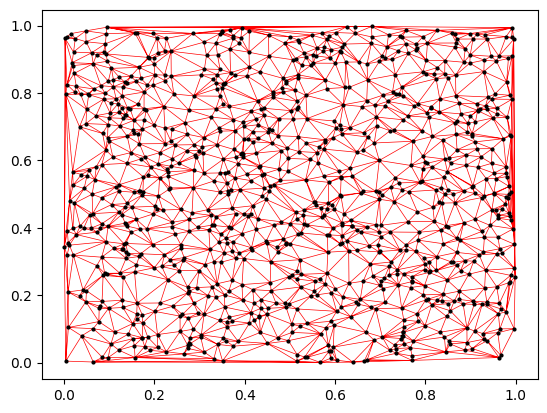

In [7]:
# expected result
plt.triplot(points[:,0], points[:,1], tri.simplices, 'r-', linewidth=0.5)
plt.plot(points[:,0], points[:,1], 'ko', markersize=2)
plt.show()

In [8]:
def Hilbert(point, depth, O, R, B):
    point, O, R, B = map(np.array, [point, O, R, B])
    index = [0] * depth
    for i in range(depth):
        dotR = np.dot(point-O, R) > 0.
        dotB = np.dot(point-O, B) > 0.
        R /= 2.
        B /= 2.
        if dotR:
            if dotB:
                index[i] = 2
                O += R + B
            else:
                index[i] = 3
                O += R - B
                R, B = B, R
        else:
            if dotB:
                index[i] = 1
                O -= R - B
            else:
                index[i] = 0
                O -= R + B
                R, B = B, R
    return index

In [9]:
def Ball(boundary, p):
    # connect p to all vertices of the cavity
    new_mesh = TriangularMesh(vertices=[p])
    hedges = sorted(boundary.halfedges, key=lambda hedge: hedge.next.vertex.coords)
    next_bdry_hedges = sorted(boundary.halfedges, key=lambda hedge: hedge.vertex.coords)
    for hedge in hedges:
        new_mesh.add_triangle([p, hedge.vertex, hedge.next.vertex], [Halfedge(), hedge, Halfedge()])
    for i, hedge in enumerate(hedges):
        hedge.next.twin = next_bdry_hedges[i].next.next
        next_bdry_hedges[i].next.next.twin = hedge.next

    return new_mesh

In [10]:
def check_triangle(halfedge, p):
    # faster implementation
    # coords2 = [v.coords for v in (halfedge.vertex, halfedge.next.vertex, halfedge.prev.vertex) if v.index >= 0]
    coords = [v.coords for v in [halfedge.vertex, halfedge.next.vertex, halfedge.prev.vertex] if v.index >= 0]

    if len(coords) == 3:
        return incircle(*coords, p.coords) >= 0
    elif len(coords) == 2:
        if halfedge.next.vertex.index < 0:
            coords = [coords[1], coords[0]]
        return orient2d(*coords, p.coords) >= 0
    else:
        quadrant = -sum(idx for idx in [halfedge.vertex.index, halfedge.next.vertex.index, halfedge.prev.vertex.index] if idx < 0)
        if quadrant == 3:
            return p.coords[1] >= coords[0][1]
        elif quadrant == 6:
            return p.coords[0] <= coords[0][0]
        elif quadrant == 12:
            return p.coords[1] <= coords[0][1]
        elif quadrant == 9:
            return p.coords[0] >= coords[0][0]
        
    print('error')
    return False

In [11]:
def check_vertex(vertex, p):
    halfedge = vertex.halfedge
    if not halfedge:
        # print('no edge for vertex', vertex)
        return None
    while True:
        if check_triangle(halfedge, p):
            return halfedge
        if halfedge.twin == None:
            break
        halfedge = halfedge.twin.next # clockwise
        if halfedge == vertex.halfedge:
            break
        if halfedge.vertex != vertex:
            print('not good', halfedge, halfedge.vertex, vertex)
            break
    return None

In [12]:
def expand(init_hedge, p):
    interior = TriangularMesh(faces={init_hedge.facet})
    boundary = TriangularMesh()

    # visited = []
    stack = deque([init_hedge, init_hedge.next, init_hedge.prev])
    while stack:
        hedge = stack.popleft()
        if hedge.twin == None:
            boundary.halfedges.add(hedge)
            # boundary.vertices.append(hedge.vertex)
            continue
        if not check_triangle(hedge.twin, p):
            boundary.halfedges.add(hedge)
            # boundary.vertices.append(hedge.vertex)
            continue
        # hedge.twin.facet.visited = True
        # visited.append(hedge.twin.facet)
        interior.halfedges.update({hedge, hedge.twin})
        interior.faces.add(hedge.twin.facet)

        stack.append(hedge.twin.next)
        stack.append(hedge.twin.prev)

    # for face in visited:
    #     face.visited = False
    
    # print('inbdr', boundary.vertices)
    return interior, boundary

In [13]:
def Cavity(mesh, p, ind):
    i = -1
    while True:
        # u = mesh.vertices[(ind + (-1)**i * i // 2)%len(mesh.vertices)]
        u = mesh.vertices[i]
        init_hedge = check_vertex(u, p)
        if init_hedge:
            break
        i -= 1
    res = expand(init_hedge, p)
    return res


In [14]:
def init(points):
    depth = 8
    O, R, B = (0.5, 0.5), (0.5, 0), (0, 0.5)
    mesh = TriangularMesh()
    for i, p in enumerate(points):
        mesh.vertices.append(Vertex(tuple(p.tolist()), Hilbert=Hilbert(p, depth, O, R, B), index=i))

    # add points at +-infinity
    infite_pts = [(np.inf, np.inf), (-np.inf, np.inf), (-np.inf, -np.inf), (np.inf, -np.inf)] # keep order!
    # infite_pts = [(1.1, 1.1), (-1.1, 1.1), (-1.1, -1.1), (1.1, -1.1)]
    for i, p in enumerate(infite_pts):
        mesh.vertices.append(Vertex(p, Hilbert = [-1]*depth, index=-(1 << i)))
    mesh.sort_vertices()
    
    # add the 4 initial triangles with infinite points and point p[0]
    return mesh

In [15]:
def draw_mesh(mesh):
    for he in mesh.halfedges:
        # if he.visited:
        #     continue
        if he.vertex.index < 0 or he.next.vertex.index < 0:
            continue
        a, b = he.vertex.coords, he.next.vertex.coords
        # plt.plot(*np.clip((a, b), -0.1, 1.1).T, 'r-')
        plt.plot(*zip(a, b), 'r-', linewidth=0.4)
        # plt.arrow(a[0], a[1], b[0]-a[0], b[1]-a[1], head_width=0.5, head_length=1, fc='r', ec='k')
    for i, p in enumerate(mesh.vertices):
        if p.index < 0:
            continue
        plt.plot(*p.coords, 'ko', markersize=2)
        # plt.text(*p.coords, str(i), fontsize=9)
    plt.show()

# draw_mesh(mesh)

In [16]:
def f(mesh):
    p = mesh.vertices[4]
    init_hedges = []
    for i in range(4):
        init_hedges += mesh.add_triangle([mesh.vertices[i], mesh.vertices[(i+1)%4], mesh.vertices[4]], out=True)
    # stick edges together
    for i in range(4):
        init_hedges[3*i + 1].twin = init_hedges[(3*i + 5) % 12]
        init_hedges[(3*i + 5) % 12].twin = init_hedges[3*i + 1]

    vertices = mesh.vertices[5:]
    mesh.vertices = mesh.vertices[:5]
    for i in range(len(vertices)):
        p = vertices[i]
        interior, boundary = Cavity(mesh, p, 5+i)
        ball = Ball(boundary, p)
        mesh.rem_mesh(boundary)
        mesh.rem_mesh(interior)
        mesh.add_mesh(ball)

    return mesh

In [40]:
start = time.time()
mesh = init(points)
f(mesh)
print('Time:', time.time() - start)
# draw_mesh(mesh)

Time: 0.11078357696533203


In [ ]:
import timeit
nums = np.linspace(1.1, 4, 50)
nums = np.power(10, nums)
res = []
resscipy = []
points = np.random.rand(2, int(nums[-1])).T
for num in nums:
    testing = points[:int(num)]
    # start = time.time()
    # tri = f(init(testing))
    # end = time.time()
    # res.append(end - start)
    # start = time.time()
    # tri = Delaunay(testing)
    # end = time.time()
    # resscipy.append(end - start)

    start = timeit.default_timer()
    tri = f(init(testing))
    end = timeit.default_timer()
    res.append(end - start)
    start = timeit.default_timer()
    tri = Delaunay(testing)
    end = timeit.default_timer()
    resscipy.append(end - start)

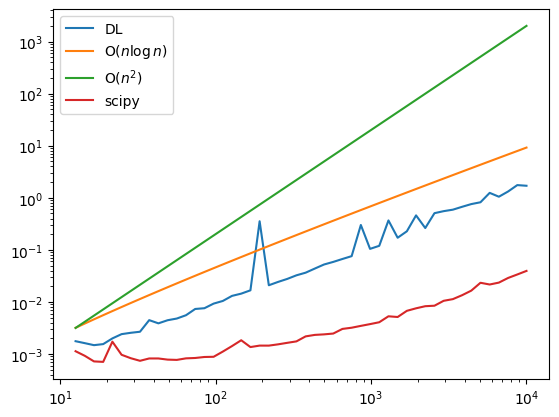

In [261]:
plt.plot(nums, res, label='DL')
plt.plot(nums, nums * np.log(nums)/10000, label=r'O($n \log n$)')
plt.plot(nums, nums*nums/50000, label=r'O($n^2$)')
plt.plot(nums, resscipy, label='scipy')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [435]:
%lprun -f Cavity -f check_triangle -f check_vertex -f expand f(init(points))

Timer unit: 1e-07 s

Total time: 1.21926 s
File: C:\Users\danny\AppData\Local\Temp\ipykernel_61296\2108953529.py
Function: expand at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def expand(init_hedge, p):
     2      9999     485828.0     48.6      4.0      interior = TriangularMesh(faces={init_hedge.facet})
     3      9999     393822.0     39.4      3.2      boundary = TriangularMesh()
     4                                           
     5                                               # visited = []
     6      9999     107319.0     10.7      0.9      stack = deque([init_hedge, init_hedge.next, init_hedge.prev])
     7    124640     615385.0      4.9      5.0      while stack:
     8    114641     520988.0      4.5      4.3          hedge = stack.popleft()
     9    114641     523365.0      4.6      4.3          if hedge.twin == None:
    10       403       2123.0      5.3      0.0              boundary.half

In [17]:
def update(mesh, v, a):
    for p in mesh.vertices:
        # boundary conditions
        if p.coords[0] < border[0] or p.coords[0] > border[1]:
            p.vel = (-p.vel[0], p.vel[1])
        if p.coords[1] < border[2] or p.coords[1] > border[3]:
            p.vel = (p.vel[0], -p.vel[1])

        p.vel = (p.vel[0] + a*p.acc[0], p.vel[1] + a*p.acc[1])
        # normalise vel
        normv = np.linalg.norm(p.vel)
        if normv > 1: p.vel = (p.vel[0]/normv, p.vel[1]/normv)
        p.coords = (p.coords[0] + v*p.vel[0], p.coords[1] + v*p.vel[1])
        p.acc = (np.random.uniform(-1, 1), np.random.uniform(-1, 1))

In [18]:
import pygame
import pygame.gfxdraw
import vidmaker
import gc

pygame 2.6.1 (SDL 2.28.4, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [24]:
FPS = 60
# render with pygame
screen = pygame.display.set_mode((800, 600))
from pygame._sdl2 import Window
Window.from_display_module().maximize()
w, h = pygame.display.get_surface().get_size()
gc.disable()

# random points in w x h rectangle
points = np.random.rand(100, 2) * [w, h]

mesh = f(init(points))
border = [min(points[:, 0]), max(points[:, 0]), min(points[:, 1]), max(points[:, 1])]

# video = vidmaker.Video("vidmaker.mp4", late_export=True, fps=60)
# video = vidmaker.Video(path="vidmaker.mp4", fps=60, resolution=(300, 300))
pygame.init()
clock = pygame.time.Clock()
L = 1
v = 0.5 *3
a = 0.05
i = 0
def render(mesh):
    global i, L
    screen.fill((255, 255, 255))

    toflip = []
    for face in mesh.faces:
        if face.index < 0:
            continue
        # pygame.gfxdraw.filled_polygon(screen, list(map(lambda x: [int(x[0]*L), int(x[1]*L)], [face.halfedge.vertex.coords, face.halfedge.next.vertex.coords, face.halfedge.prev.vertex.coords])), np.random.randint(0, 255, 3))

        if any(np.isinf(v.coords[0]) for v in [face.halfedge.vertex, face.halfedge.next.vertex, face.halfedge.prev.vertex]):
            continue

        pygame.gfxdraw.filled_polygon(screen, list(map(lambda x: [int(x[0]*L), int(x[1]*L)], [face.halfedge.vertex.coords, face.halfedge.next.vertex.coords, face.halfedge.prev.vertex.coords])), np.random.randint(0, 255, 3))

        pygame.gfxdraw.aapolygon(screen, list(map(lambda x: [int(x[0]*L), int(x[1]*L)], [face.halfedge.vertex.coords, face.halfedge.next.vertex.coords, face.halfedge.prev.vertex.coords])), (0, 0, 0))

    #     toflip += mesh.check(face.halfedge)

    # print(len(toflip))

    # for he in toflip:
    #     mesh.flip(he)
    
    

    # for he in mesh.halfedges:
    #     if he.index:
    #         continue
    #     if he.twin is not None:
    #         he.twin.index = 1
    #     a, b = he.vertex.coords, he.next.vertex.coords
    #     if np.isinf(a[0]) or np.isinf(b[0]):
    #         continue
    #     pygame.draw.aaline(screen, (0, 0, 0), (a[0]*L, a[1]*L), (b[0]*L, b[1]*L), 1)
      
    # for p in mesh.vertices:
    #     if np.isinf(p.coords[0]):
    #         continue
    #     pygame.draw.circle(screen, (0, 0, 0), p.coords, 2)
    pygame.display.flip()
    i += 1

    # for he in mesh.halfedges:
    #     he.index = 0

    update(mesh, v, a)
    mesh.faces = set()
    mesh.halfedges = set()
    mesh = f(mesh)
    # print(1)

running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
    # video.update(pygame.surfarray.pixels3d(screen).swapaxes(0, 1), inverted=False)
    render(mesh)
    clock.tick(FPS)
    # print(clock.get_fps())
pygame.quit()

# video.export(verbose=True)

In [148]:
video.export(verbose=True)

Location: vidmaker.mp4
Format: .mp4
Resolution: (np.int64(800), np.int64(600))
FPS: 60
Duration: 24.4 seconds


Compiling: 100%|██████████| 1392/1392 [00:18<00:00, 74.24frames/s]


File size: 46.78 MB


In [56]:
# use pyqt5
import sys
from PyQt5.QtWidgets import QApplication, QMainWindow
import pyqtgraph as pg

app = QApplication(sys.argv)
win = QMainWindow()
win.setGeometry(100, 100, 800, 800)

plot_widget = pg.GraphicsLayoutWidget()
win.setCentralWidget(plot_widget)
plot = plot_widget.addPlot()
plot.setAspectLocked()

def render(mesh):
    plot.clear()
    for face in mesh.faces:
        if face.index < 0:
            continue
        plot.plot([face.halfedge.vertex.coords[0], face.halfedge.next.vertex.coords[0], face.halfedge.prev.vertex.coords[0]], [face.halfedge.vertex.coords[1], face.halfedge.next.vertex.coords[1], face.halfedge.prev.vertex.coords[1]], pen=(255, 0, 0))

    # for he in mesh.halfedges:
    #     if he.index:
    #         continue
    #     if he.twin is not None:
    #         he.twin.index = 1
    #     a, b = he.vertex.coords, he.next.vertex.coords
    #     if np.isinf(a[0]) or np.isinf(b[0]):
    #         continue
    #     plot.plot([a[0], b[0]], [a[1], b[1]], pen=(0, 0, 0))
      
    # for p in mesh.vertices:
    #     if np.isinf(p.coords[0]):
    #         continue
    #     plot.plot([p.coords[0]], [p.coords[1]], pen=(0, 0, 0), symbol='o', symbolSize=2)

render(mesh)
win.show()

sys.exit(app.exec_())


SystemExit: 0

C:\Users\danny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [461]:
%timeit np.isnan(([2, 3], [4, 5]))

1.65 μs ± 139 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [462]:
%timeit ([2, 3], [4, 5]) == ([2, 3], [4, 5])

272 ns ± 22.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [ ]:
from line_profiler import LineProfiler
def check_triangle_wrapper():
	for vertex in mesh.vertices:
		for halfedge in vertex.halfedges:
			check_triangle(halfedge, vertex)

profiler = LineProfiler()
profiler.add_function(check_triangle_wrapper)
profiler.add_function(f)
profiler.run('f()')
profiler.print_stats()


TypeError: check_triangle() missing 1 required positional argument: 'p'

In [ ]:
test_p = points
test_p = [Vertex(p, index=i) for i, p in enumerate(test_p)]
test_e = [Halfedge(vertex=p) for p in test_p]
test_e = [Halfedge(vertex=p, next=test_e[(i+1)%len(test_e)], prev=test_e[(i-1)%len(test_e)]) for i, p in enumerate(test_p)]
test_mesh = TriangularMesh()
test_mesh.vertices = test_p
test_mesh.halfedges = test_e
# plot points
plt.plot(*zip(*map(lambda x: x.coords, test_mesh.vertices)), 'ko')
# plot edges
for hedge in test_mesh.halfedges:
    # draw arrow
    plt.arrow(*hedge.vertex.coords, hedge.next.vertex.coords[0] - hedge.vertex.coords[0], hedge.next.vertex.coords[1] - hedge.vertex.coords[1], head_width=0.1)
plt.show()

In [ ]:
print(test_mesh.halfedges[0].coords)

In [ ]:
ball = Ball(test_mesh, Vertex((1, 1)), 0)
# plot points
plt.plot(*zip(*map(lambda x: x.coords, ball.vertices)), 'bo')
# plot edges
for abc in ball.halfedges:
    print(abc.vertex.coords, abc.next.vertex.coords)
    plt.plot(*zip(abc.vertex.coords, abc.next.vertex.coords), 'g-')
plt.show()

In [ ]:
def DL(points):
    
    # sort points according to Hilbert curve
    depth = 8
    O = np.array([0.5, 0.5])
    R = np.array([0.5, 0])
    B = np.array([0, 0.5])
    indices = [Hilbert(point, depth, O, R, B) for point in points]
    indices = sorted(range(len(indices)), key=lambda i: indices[i])
    mesh = TriangularMesh()
    # create super triangle
    A = Vertex((border[0] - 1, border[2] - 1))
    B = Vertex((border[1] + 1, border[2] - 1))
    C = Vertex((border[0] + border[1], border[3] + 1))
    super_triangle = Face()
    super_triangle.halfedge = Halfedge(vertex=A, next=Halfedge(vertex=B, next=Halfedge(vertex=C, next=Halfedge(vertex=A, facet=super_triangle))))
    super_triangle.index = 0
    mesh.add_mesh(TriangularMesh(vertices=[A, B, C], faces=[super_triangle], halfedges=[super_triangle.halfedge, super_triangle.halfedge.next, super_triangle.halfedge.next.next, super_triangle.halfedge.next.next.next]))
    for i in indices:
        cavity = Cavity(mesh, Vertex(points[i]), i)
        mesh.add_mesh(Ball(cavity, Vertex(points[i]), i))
    return mesh

In [ ]:
orient2d((0., 0.), (0.5, 0.), (np.inf, -0.1))

In [ ]:
%timeit incircle(np.array([0., 0.]), np.array([1., 0.]), np.array([0., 1.]), np.array([0.5, -0.1]))

In [ ]:
%timeit incircle((0., 0.), (1., 0.), (0., 1.), (0.5, -0.1))

In [ ]:
def test(a, b, c, p):
    # if one of the points has index -1, do orient2d instead of incircle
    if -1 in [a.index, b.index, c.index]:
        return orient2d(a.coords, b.coords, c.coords)


In [ ]:
import math
sys.float_info.max/1e139

In [ ]:
%timeit incircle((0., 0.), (1., 0.), (0., 1.0), (0.5, -0.15))

In [ ]:
%timeit incircle((np.float64(0.), np.float64(0.)), (np.float64(1.), np.float64(0.)), (np.float64(0.), np.float64(1.0)), (np.float64(0.5), np.float64(-0.15)))

In [ ]:
a = [(0., 0.), (1., 0.), (0., 1.0), (0.5, -0.15)]
# a = [[0., 0.], [1., 0.], [0., 1.0], [0.5, -0.15]]
# a = [(np.float64(0.), np.float64(0.)), (np.float64(1.), np.float64(0.)), (np.float64(0.), np.float64(1.0)), (np.float64(0.5), np.float64(-0.15))]
# a = [np.array([0., 0.]), np.array([1., 0.]), np.array([0., 1.0]), np.array([0.5, -0.15])]
# a = np.array([[0., 0.], [1., 0.], [0., 1.0], [0.5, -0.15]])
%timeit incircle(a[0], a[1], a[2], a[3])

In [ ]:
arr = np.random.rand(10000000, 2)
%timeit arr2 = list(map(tuple, arr.tolist()))

In [ ]:
%timeit incircle((np.float32(0.), np.float32(0.)), (np.float32(1.), np.float32(0.)), (np.float32(0.), np.float32(1.0)), (np.float32(0.5), np.float32(-0.15)))

In [ ]:
%timeit incircle((np.float16(0.), np.float16(0.)), (np.float16(1.), np.float16(0.)), (np.float16(0.), np.float16(1.0)), (np.float16(0.5), np.float16(-0.15)))

In [ ]:
%timeit incircle([0., 0.], [1., 0.], [0., 1.], [0.5, -0.1])

In [83]:
a = list(map(tuple, np.random.rand(2, 10).T))

In [ ]:
%timeit incircle(a[0], a[1], a[2], a[3])

In [ ]:
points

In [ ]:
np.random.rand(10, 2)

In [31]:
b = sorted(np.random.rand(100, 2), key=lambda x: Hilbert(x, depth, np.array([0.5, 0.5]), np.array([0.5, 0.]), np.array([0., 0.5])))

In [32]:
insort(b, np.array([0.51, 0.49]), key=lambda x: Hilbert(x, depth, np.array([0.5, 0.5]), np.array([0.5, 0.]), np.array([0., 0.5])))

In [ ]:
for i, p in enumerate(b):
    plt.plot(p[0], p[1], 'ko')
    # write index
    plt.text(p[0], p[1], str(i))
plt.plot(b[-1][0], b[-1][1], 'ro')
plt.show()


In [ ]:
class test:
    def __init__(self, a, b):
        self.a = a
        self.b = b
    def __repr__(self):
        return str(self.a-self.b)

l = [] 
for i in range(10):
    l.append(test(4*i**2, 3*i))

print(l[3].b)